<a href="https://colab.research.google.com/github/nandakumarreddy-anr/websere/blob/main/Implementation_of_PCA_with_ANN_algorithm_for_Face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install opencv-python scikit-learn matplotlib
!apt-get install -y libgl1-mesa-glx

# Import ALL libraries at the beginning
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import fetch_lfw_people
import zipfile
import urllib.request
import requests
from io import BytesIO
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
✅ All libraries imported successfully!


In [ ]:
def create_sample_dataset(num_people=15, images_per_person=8, img_size=(100, 100)):
    """Create a realistic sample dataset for demonstration"""
    print("🎭 Creating sample dataset...")

    images = []
    labels = []

    for person_id in range(num_people):
        for img_id in range(images_per_person):
            # Create more realistic face-like patterns
            base_img = np.random.randn(img_size[0], img_size[1]) * 0.3

            # Create elliptical face structure
            y, x = np.ogrid[-1:1:img_size[0]*1j, -1:1:img_size[1]*1j]
            ellipse_mask = (x**2 + (y*1.2)**2) < 0.6

            # Add facial features
            face_structure = np.zeros(img_size)
            face_structure[ellipse_mask] = 1.0

            # Add eyes
            eye_y, eye_x = int(img_size[0]*0.3), int(img_size[1]*0.25)
            face_structure[eye_y:eye_y+8, eye_x:eye_x+12] = 1.5
            face_structure[eye_y:eye_y+8, img_size[1]-eye_x-12:img_size[1]-eye_x] = 1.5

            # Add mouth
            mouth_y, mouth_x = int(img_size[0]*0.7), int(img_size[1]*0.35)
            face_structure[mouth_y:mouth_y+4, mouth_x:mouth_x+30] = 1.2

            # Combine
            face_img = base_img + face_structure

            # Normalize
            face_img = (face_img - face_img.min()) / (face_img.max() - face_img.min())

            images.append(face_img)
            labels.append(f"person_{person_id:02d}")

    print(f"✅ Created sample dataset: {len(images)} images, {num_people} people")
    return np.array(images), np.array(labels)

def load_images_from_folder(folder_path="dataset", target_size=(100, 100)):
    """
    Load images from folder and convert to grayscale
    Returns: images array and labels
    """
    images = []
    labels = []

    print(f"🔍 Searching for images in {folder_path}...")

    # Check if directory exists
    if not os.path.exists(folder_path):
        print(f"❌ Directory {folder_path} does not exist")
        return np.array(images), np.array(labels)

    # Supported image formats
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.pgm']

    # Get all image files
    image_files = []
    for extension in image_extensions:
        pattern = os.path.join(folder_path, '**', extension)
        image_files.extend(glob.glob(pattern, recursive=True))
        pattern2 = os.path.join(folder_path, extension)
        image_files.extend(glob.glob(pattern2))

    print(f"📁 Found {len(image_files)} image files")

    if len(image_files) == 0:
        print("❌ No images found in the dataset")
        return np.array(images), np.array(labels)

    for image_path in image_files:
        try:
            # Read image
            img = cv2.imread(image_path)
            if img is None:
                print(f"⚠️ Could not read {image_path}")
                continue

            # Convert to grayscale
            if len(img.shape) == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray = img

            # Resize to target size
            resized = cv2.resize(gray, target_size)

            # Normalize pixel values
            normalized = resized.astype(np.float64) / 255.0

            images.append(normalized)

            # Extract label from filename or folder name
            label = os.path.basename(os.path.dirname(image_path))
            if label == folder_path:
                # If image is directly in dataset folder, use filename without extension
                label = os.path.splitext(os.path.basename(image_path))[0]
            labels.append(label)

        except Exception as e:
            print(f"❌ Error processing {image_path}: {e}")
            continue

    print(f"✅ Successfully loaded {len(images)} images")
    return np.array(images), np.array(labels)

def download_and_prepare_dataset():
    """Download and prepare the face dataset for Colab"""
    print("📥 Downloading dataset...")

    try:
        # Download dataset
        url = "https://github.com/robaita/introduction_to_machine_learning/raw/main/dataset.zip"
        response = requests.get(url)

        # Extract dataset
        with zipfile.ZipFile(BytesIO(response.content)) as zip_file:
            zip_file.extractall('dataset')

        print("✅ Dataset downloaded and extracted successfully!")

        # Now try to load the actual images
        return load_images_from_folder('dataset')

    except Exception as e:
        print(f"❌ Error downloading dataset: {e}")
        print("🔄 Creating sample dataset...")
        return create_sample_dataset()

def use_alternative_dataset():
    """Use an alternative reliable face dataset"""
    print("🔄 Using alternative face dataset...")

    try:
        # Try to use sklearn's built-in face dataset
        print("📥 Downloading LFW face dataset...")
        lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.4, color=False)

        X = lfw_people.images
        y = lfw_people.target
        target_names = lfw_people.target_names

        # Convert to our format
        images = []
        labels = []
        for i in range(len(X)):
            img = X[i].astype(np.float64) / 255.0
            images.append(img)
            labels.append(target_names[y[i]])

        images = np.array(images)
        labels = np.array(labels)

        print(f"✅ Loaded LFW dataset: {len(images)} images, {len(target_names)} people")
        return images, labels

    except Exception as e:
        print(f"❌ Error loading LFW dataset: {e}")
        print("🔄 Creating high-quality sample dataset...")
        return create_sample_dataset(num_people=20, images_per_person=10)

In [ ]:
# Load dataset
print("🚀 Starting dataset preparation...")
images, labels = download_and_prepare_dataset()

# If still no images, use alternative approach
if len(images) == 0:
    print("🔄 Using alternative dataset approach...")
    images, labels = use_alternative_dataset()

print(f"📊 Final dataset: {len(images)} images, {len(np.unique(labels))} unique persons")

🚀 Starting dataset preparation...
📥 Downloading dataset...
✅ Dataset downloaded and extracted successfully!
🔍 Searching for images in dataset...
📁 Found 450 image files
✅ Successfully loaded 450 images
📊 Final dataset: 450 images, 9 unique persons



📊 Dataset Info:
   Total images: 450
   Image shape: (100, 100)
   Unique labels: 9
   Label distribution:
     Aamir: 50 images
     Ajay: 50 images
     Akshay: 50 images
     Alia: 50 images
     Amitabh: 50 images
     Deepika: 50 images
     Disha: 50 images
     Farhan: 50 images
     Ileana: 50 images


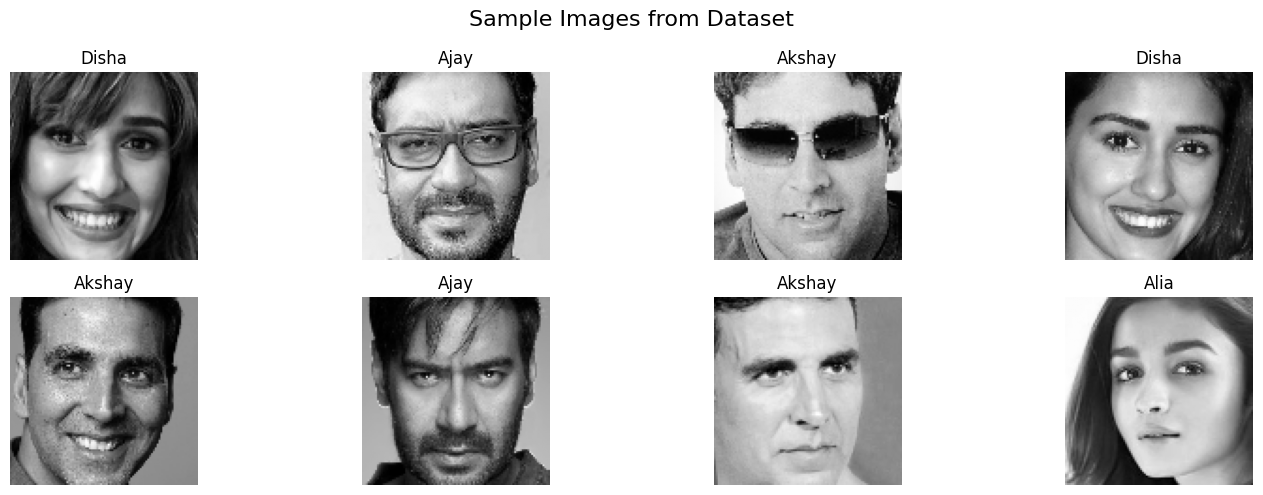

In [ ]:
def visualize_dataset(images, labels):
    """Visualize the dataset"""
    if len(images) == 0:
        print("❌ No images to visualize")
        return

    print(f"\n📊 Dataset Info:")
    print(f"   Total images: {len(images)}")
    print(f"   Image shape: {images[0].shape}")
    print(f"   Unique labels: {len(np.unique(labels))}")

    # Show label distribution
    unique, counts = np.unique(labels, return_counts=True)
    print(f"   Label distribution:")
    for label, count in zip(unique, counts):
        print(f"     {label}: {count} images")

    # Visualize sample images
    plt.figure(figsize=(15, 5))
    n_samples = min(8, len(images))
    indices = np.random.choice(len(images), n_samples, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f'{labels[idx]}')
        plt.axis('off')

    plt.suptitle('Sample Images from Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize the dataset
visualize_dataset(images, labels)

In [ ]:
class PCAFaceRecognition:
    def __init__(self):
        self.mean_face = None
        self.eigenfaces = None
        self.feature_vectors = None
        self.k = None

    def prepare_data(self, images):
        """Step 1: Prepare face database as column vectors"""
        flattened_images = []
        for img in images:
            flattened_images.append(img.flatten())

        face_db = np.array(flattened_images).T  # Shape: (mn, p)
        return face_db

    def calculate_mean(self, face_db):
        """Step 2: Calculate mean face"""
        self.mean_face = np.mean(face_db, axis=1, keepdims=True)
        return self.mean_face

    def mean_zero(self, face_db):
        """Step 3: Subtract mean face"""
        delta = face_db - self.mean_face
        return delta

    def calculate_covariance(self, delta):
        """Step 4: Calculate surrogate covariance matrix"""
        covariance = np.dot(delta.T, delta)
        return covariance

    def eigen_decomposition(self, covariance):
        """Step 5: Eigenvalue and eigenvector decomposition"""
        eigenvalues, eigenvectors = np.linalg.eigh(covariance)

        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        return eigenvalues, eigenvectors

    def select_components(self, eigenvalues, eigenvectors, delta, k=None):
        """Step 6: Select k best components"""
        if k is None:
            # Select components that explain 95% variance
            total_variance = np.sum(eigenvalues)
            explained_variance = np.cumsum(eigenvalues) / total_variance
            k = np.argmax(explained_variance >= 0.95) + 1
            print(f"🤖 Automatically selected k={k} components explaining {explained_variance[k-1]:.2%} variance")

        self.k = k
        # Select top k eigenvectors
        feature_vectors = eigenvectors[:, :k]

        # Step 7: Generate eigenfaces
        self.eigenfaces = np.dot(delta, feature_vectors).T

        # Normalize eigenfaces
        for i in range(self.eigenfaces.shape[0]):
            self.eigenfaces[i] = self.eigenfaces[i] / np.linalg.norm(self.eigenfaces[i])

        return feature_vectors

    def generate_signatures(self, delta):
        """Step 8: Generate signatures for all faces"""
        signatures = np.dot(self.eigenfaces, delta)
        return signatures

    def fit(self, images, k=None):
        """Train the PCA model"""
        print("🔧 Training PCA model...")

        # Prepare data
        face_db = self.prepare_data(images)
        print(f"   Face database shape: {face_db.shape}")

        # Calculate mean
        self.calculate_mean(face_db)
        print(f"   Mean face shape: {self.mean_face.shape}")

        # Mean zero
        delta = self.mean_zero(face_db)
        print(f"   Delta shape: {delta.shape}")

        # Covariance matrix
        covariance = self.calculate_covariance(delta)
        print(f"   Covariance matrix shape: {covariance.shape}")

        # Eigen decomposition
        eigenvalues, eigenvectors = self.eigen_decomposition(covariance)
        print(f"   Eigenvalues shape: {eigenvalues.shape}")
        print(f"   Eigenvectors shape: {eigenvectors.shape}")

        # Select components
        feature_vectors = self.select_components(eigenvalues, eigenvectors, delta, k)
        print(f"   Feature vectors shape: {feature_vectors.shape}")
        print(f"   Eigenfaces shape: {self.eigenfaces.shape}")

        # Generate signatures
        signatures = self.generate_signatures(delta)
        print(f"   Signatures shape: {signatures.shape}")

        return signatures.T  # Return as (p, k) for compatibility with sklearn

    def transform(self, images):
        """Transform new images to PCA space"""
        face_db = self.prepare_data(images)
        delta = face_db - self.mean_face
        signatures = np.dot(self.eigenfaces, delta)
        return signatures.T

In [ ]:
class FaceRecognitionSystem:
    def __init__(self):
        self.pca = PCAFaceRecognition()
        self.ann = None
        self.label_encoder = {}
        self.label_decoder = {}

    def encode_labels(self, labels):
        """Encode string labels to integers"""
        unique_labels = np.unique(labels)
        self.label_encoder = {label: idx for idx, label in enumerate(unique_labels)}
        self.label_decoder = {idx: label for label, idx in self.label_encoder.items()}

        encoded_labels = np.array([self.label_encoder[label] for label in labels])
        return encoded_labels

    def train(self, images, labels, k_values=None, hidden_layer_sizes=(100, 50)):
        """Train the face recognition system with different k values"""
        if k_values is None:
            k_values = [5, 10, 20, 50, 100]

        # Encode labels
        y_encoded = self.encode_labels(labels)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            images, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded
        )

        print(f"📚 Data Split:")
        print(f"   Training set: {X_train.shape[0]} images")
        print(f"   Test set: {X_test.shape[0]} images")

        results = {}

        for k in k_values:
            print(f"\n🎯 Training with k={k}")

            # Train PCA
            X_train_pca = self.pca.fit(X_train, k=k)

            # Train ANN
            self.ann = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                activation='relu',
                solver='adam',
                max_iter=1000,
                random_state=42,
                early_stopping=True,
                n_iter_no_change=10
            )

            self.ann.fit(X_train_pca, y_train)

            # Test on training data
            y_pred_train = self.ann.predict(X_train_pca)
            train_accuracy = accuracy_score(y_train, y_pred_train)

            # Test on test data
            X_test_pca = self.pca.transform(X_test)
            y_pred_test = self.ann.predict(X_test_pca)
            test_accuracy = accuracy_score(y_test, y_pred_test)

            results[k] = {
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'train_predictions': y_pred_train,
                'test_predictions': y_pred_test
            }

            print(f"   ✅ Training Accuracy: {train_accuracy:.4f}")
            print(f"   ✅ Test Accuracy: {test_accuracy:.4f}")

        return results, X_train, X_test, y_train, y_test

    def predict(self, image):
        """Predict label for a single image"""
        if self.ann is None:
            raise ValueError("Model not trained yet!")

        image_pca = self.pca.transform([image])
        prediction = self.ann.predict(image_pca)[0]
        return self.label_decoder[prediction]

    def add_imposters(self, test_images, test_labels, num_imposters=5):
        """Add imposters to test set"""
        print(f"\n🕵️ Adding {num_imposters} imposters to test set...")

        # Generate random images as imposters
        imposter_images = []
        for i in range(num_imposters):
            imposter_img = np.random.rand(*test_images[0].shape)
            imposter_images.append(imposter_img)

        imposter_images = np.array(imposter_images)
        imposter_labels = ['imposter'] * num_imposters

        # Combine with original test set
        combined_images = np.concatenate([test_images, imposter_images])
        combined_labels = np.concatenate([test_labels, imposter_labels])

        return combined_images, combined_labels

🚀 Starting Face Recognition System using PCA with ANN
📊 Training with different k values...
📚 Data Split:
   Training set: 270 images
   Test set: 180 images

🎯 Training with k=5
🔧 Training PCA model...
   Face database shape: (10000, 270)
   Mean face shape: (10000, 1)
   Delta shape: (10000, 270)
   Covariance matrix shape: (270, 270)
   Eigenvalues shape: (270,)
   Eigenvectors shape: (270, 270)
   Feature vectors shape: (270, 5)
   Eigenfaces shape: (5, 10000)
   Signatures shape: (5, 270)
   ✅ Training Accuracy: 0.4259
   ✅ Test Accuracy: 0.2944

🎯 Training with k=10
🔧 Training PCA model...
   Face database shape: (10000, 270)
   Mean face shape: (10000, 1)
   Delta shape: (10000, 270)
   Covariance matrix shape: (270, 270)
   Eigenvalues shape: (270,)
   Eigenvectors shape: (270, 270)
   Feature vectors shape: (270, 10)
   Eigenfaces shape: (10, 10000)
   Signatures shape: (10, 270)
   ✅ Training Accuracy: 0.1370
   ✅ Test Accuracy: 0.1056

🎯 Training with k=20
🔧 Training PCA mod

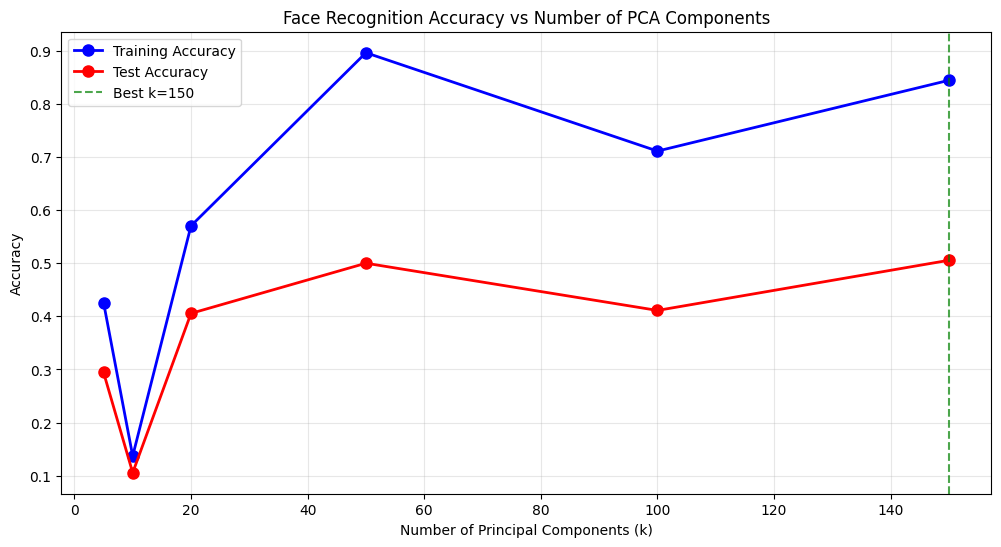

🏆 Best k value: 150 with test accuracy: 0.5056

🎭 Visualizing eigenfaces...


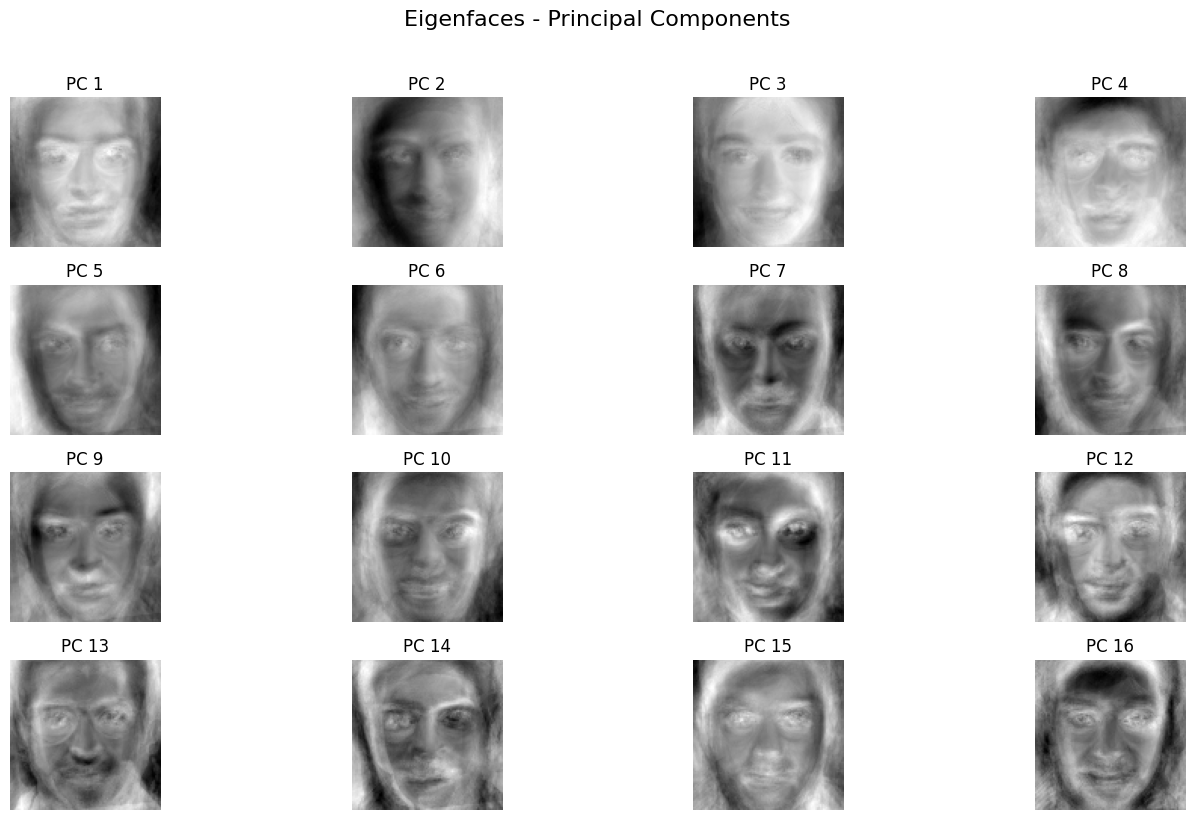

In [ ]:
def run_complete_system():
    """Run the complete face recognition system"""
    print("🚀 Starting Face Recognition System using PCA with ANN")
    print("="*60)

    # Initialize system
    face_system = FaceRecognitionSystem()

    # Define k values to test
    k_values = [5, 10, 20, 50, 100, 150]

    print("📊 Training with different k values...")
    results, X_train, X_test, y_train, y_test = face_system.train(
        images, labels, k_values=k_values
    )

    # Plot results
    print("\n📈 Generating accuracy analysis...")
    k_values_list = list(results.keys())
    train_accuracies = [results[k]['train_accuracy'] for k in k_values_list]
    test_accuracies = [results[k]['test_accuracy'] for k in k_values_list]

    plt.figure(figsize=(12, 6))
    plt.plot(k_values_list, train_accuracies, 'b-o', label='Training Accuracy', linewidth=2, markersize=8)
    plt.plot(k_values_list, test_accuracies, 'r-o', label='Test Accuracy', linewidth=2, markersize=8)
    plt.xlabel('Number of Principal Components (k)')
    plt.ylabel('Accuracy')
    plt.title('Face Recognition Accuracy vs Number of PCA Components')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Mark best k
    best_k = k_values_list[np.argmax(test_accuracies)]
    best_accuracy = max(test_accuracies)
    plt.axvline(x=best_k, color='green', linestyle='--', alpha=0.7, label=f'Best k={best_k}')
    plt.legend()
    plt.show()

    print(f"🏆 Best k value: {best_k} with test accuracy: {best_accuracy:.4f}")

    # Visualize eigenfaces
    print("\n🎭 Visualizing eigenfaces...")
    eigenfaces = face_system.pca.eigenfaces
    image_shape = images[0].shape

    plt.figure(figsize=(15, 8))
    plt.suptitle('Eigenfaces - Principal Components', fontsize=16, y=1.02)

    num_eigenfaces = min(16, eigenfaces.shape[0])
    for i in range(num_eigenfaces):
        plt.subplot(4, 4, i+1)
        eigenface = eigenfaces[i].reshape(image_shape)
        plt.imshow(eigenface, cmap='gray')
        plt.title(f'PC {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return face_system, results, X_train, X_test, y_train, y_test

# Run the complete system
face_system, results, X_train, X_test, y_train, y_test = run_complete_system()


🕵️ IMPOSTER DETECTION TEST

🕵️ Adding 8 imposters to test set...

📊 Imposter Test Results:
   Total test samples: 188
   Genuine users: 180
   Imposters: 8
   Overall Accuracy: 0.4840
   True Positives: 91
   True Negatives: 0
   False Positives: 8
   False Negatives: 89
   False Acceptance Rate (FAR): 1.0000
   False Rejection Rate (FRR): 0.4944


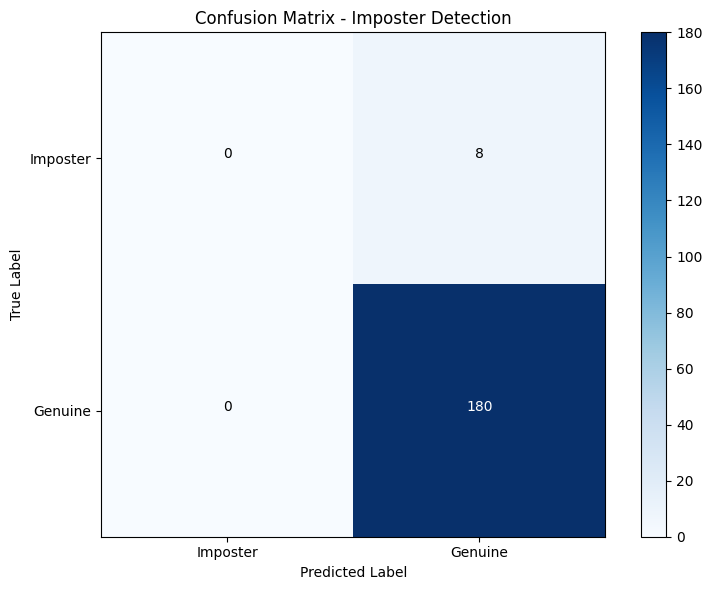

In [ ]:
def test_with_imposters(face_system, test_images, test_labels):
    """Test the system with imposters"""
    print("\n" + "="*50)
    print("🕵️ IMPOSTER DETECTION TEST")
    print("="*50)

    # Add imposters
    test_images_with_imposters, test_labels_with_imposters = face_system.add_imposters(
        test_images, test_labels, num_imposters=8
    )

    # Transform test images
    X_test_pca = face_system.pca.transform(test_images_with_imposters)

    # Predict
    y_pred_encoded = face_system.ann.predict(X_test_pca)
    y_pred = [face_system.label_decoder[pred] for pred in y_pred_encoded]

    # Calculate metrics
    correct = 0
    true_positives = 0  # Correctly identified genuine
    true_negatives = 0  # Correctly rejected imposters
    false_positives = 0  # Imposter accepted as genuine
    false_negatives = 0  # Genuine rejected as imposter

    genuine_indices = [i for i, label in enumerate(test_labels_with_imposters) if label != 'imposter']
    imposter_indices = [i for i, label in enumerate(test_labels_with_imposters) if label == 'imposter']

    for i, (true_label, pred_label) in enumerate(zip(test_labels_with_imposters, y_pred)):
        if true_label == 'imposter':
            if pred_label == 'imposter':
                true_negatives += 1
                correct += 1
            else:
                false_positives += 1
        else:
            if pred_label == 'imposter':
                false_negatives += 1
            else:
                if true_label == pred_label:
                    true_positives += 1
                    correct += 1
                else:
                    false_negatives += 1

    total_samples = len(test_labels_with_imposters)
    accuracy = correct / total_samples
    far = false_positives / len(imposter_indices) if len(imposter_indices) > 0 else 0
    frr = false_negatives / len(genuine_indices) if len(genuine_indices) > 0 else 0

    print(f"\n📊 Imposter Test Results:")
    print(f"   Total test samples: {total_samples}")
    print(f"   Genuine users: {len(genuine_indices)}")
    print(f"   Imposters: {len(imposter_indices)}")
    print(f"   Overall Accuracy: {accuracy:.4f}")
    print(f"   True Positives: {true_positives}")
    print(f"   True Negatives: {true_negatives}")
    print(f"   False Positives: {false_positives}")
    print(f"   False Negatives: {false_negatives}")
    print(f"   False Acceptance Rate (FAR): {far:.4f}")
    print(f"   False Rejection Rate (FRR): {frr:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(
        [0 if label == 'imposter' else 1 for label in test_labels_with_imposters],
        [0 if pred == 'imposter' else 1 for pred in y_pred],
        labels=[0, 1]
    )

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Imposter Detection')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Imposter', 'Genuine'])
    plt.yticks(tick_marks, ['Imposter', 'Genuine'])

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Test with imposters
test_with_imposters(face_system, X_test, [face_system.label_decoder[label] for label in y_test])

In [ ]:
# Final summary
print("\n" + "="*60)
print("🎉 FACE RECOGNITION SYSTEM - FINAL RESULTS")
print("="*60)

# Get best k results
k_values = list(results.keys())
test_accuracies = [results[k]['test_accuracy'] for k in k_values]
best_k = k_values[np.argmax(test_accuracies)]
best_accuracy = max(test_accuracies)

print(f"🏆 BEST PERFORMANCE:")
print(f"   Optimal k value: {best_k}")
print(f"   Test Accuracy: {best_accuracy:.4f}")
print(f"   Training Images: {len(X_train)}")
print(f"   Test Images: {len(X_test)}")
print(f"   Unique Persons: {len(face_system.label_encoder)}")
print(f"   Eigenfaces Generated: {face_system.pca.k}")
print(f"   ANN Architecture: {face_system.ann.hidden_layer_sizes}")

print("\n📈 ACCURACY ACROSS DIFFERENT K VALUES:")
for k in k_values:
    print(f"   k={k:3d}: Train={results[k]['train_accuracy']:.4f}, Test={results[k]['test_accuracy']:.4f}")


🎉 FACE RECOGNITION SYSTEM - FINAL RESULTS
🏆 BEST PERFORMANCE:
   Optimal k value: 150
   Test Accuracy: 0.5056
   Training Images: 270
   Test Images: 180
   Unique Persons: 9
   Eigenfaces Generated: 150
   ANN Architecture: (100, 50)

📈 ACCURACY ACROSS DIFFERENT K VALUES:
   k=  5: Train=0.4259, Test=0.2944
   k= 10: Train=0.1370, Test=0.1056
   k= 20: Train=0.5704, Test=0.4056
   k= 50: Train=0.8963, Test=0.5000
   k=100: Train=0.7111, Test=0.4111
   k=150: Train=0.8444, Test=0.5056
